In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

In [2]:
def show_img(img):
    img = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [50]:
left_files = sorted(glob('./stage2_data/stage2_stereo/left_imgs/*'))
right_files = sorted(glob('./stage2_data/stage2_stereo/right_imgs/*'))
dp_files = sorted(glob('./stage2_data/stage2_stereo/disparities/*'))

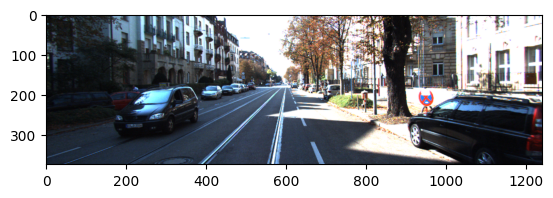

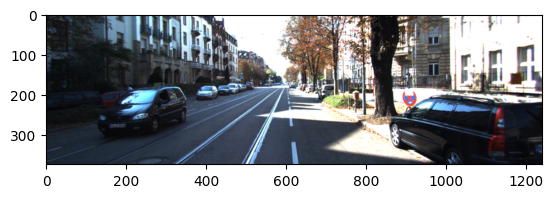

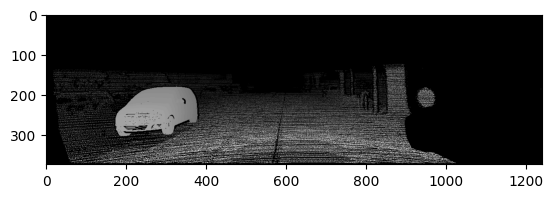

In [55]:
show_img(cv2.imread(left_files[0])),show_img(cv2.imread(right_files[0])),plt.imshow(cv2.imread(dp_files[0],0),'gray')
plt.show()

## StereoBM

In [84]:
img_left = cv2.imread(left_files[0], 0)
img_right = cv2.imread(right_files[0], 0)
disparity_gn = cv2.imread(dp_files[0], 0)

max_disparity_list = [i*16 for i in range(1,11)]
block_size_list = [i for i in range(5,64,2)]
rmse_list = list()
min_rmse = 999
min_parm = tuple

for max_disparity in tqdm(max_disparity_list):
    for block_size in block_size_list:
        stereo = cv2.StereoBM_create(numDisparities=max_disparity, blockSize=block_size)
        disparity = stereo.compute(img_left, img_right)
        disparity = cv2.normalize(disparity, None, alpha=0, beta=max_disparity, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        mask = np.logical_or(disparity == 0, disparity_gn == 0)
        masked_RMSE = np.ma.array(np.square(disparity - disparity_gn), mask=mask)
        rmse = (np.mean(masked_RMSE))**(0.5)
        rmse_list.append(rmse)
        if rmse < min_rmse:
            min_rmse = rmse
            min_parm = (max_disparity, block_size)

# plt.imshow(masked_disp, 'gray')
# plt.show()
# plt.imshow(disparity_gn, 'gray')
# plt.show()

100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


In [85]:
min_rmse, min_parm

(2.469514930706023, (48, 63))

Masked RMSE for Stereo BM: 2.469514930706023 with density: 0.03945464304884594


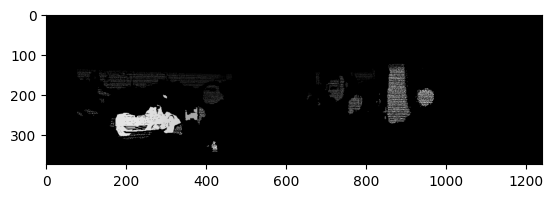

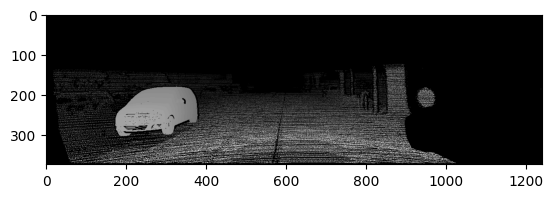

In [87]:
stereo = cv2.StereoBM_create(numDisparities = 48, blockSize = 63)
disparity = stereo.compute(img_left, img_right)
disparity = cv2.normalize(disparity, None, alpha=0, beta=48, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
mask = np.logical_or(disparity == 0, disparity_gn == 0)
masked_RMSE = np.ma.array(np.square(disparity - disparity_gn), mask=mask)
rmse = (np.mean(masked_RMSE))**(0.5)
masked_disp = disparity.copy()
masked_disp[mask] = 0
print(f'Masked RMSE for Stereo BM: {rmse} with density: {1 - np.mean(mask)}')
plt.imshow(masked_disp, 'gray')
plt.show()
plt.imshow(disparity_gn, 'gray')
plt.show()

## SGBM

In [89]:
# Load the left and right images in grayscale
img_left = cv2.imread(left_files[0], 0)
img_right = cv2.imread(right_files[0], 0)

max_disparity_list = [i*16 for i in range(1,11)]
block_size_list = [i for i in range(5,64,2)]
# window_size_list = [i for i in range(5,16)]
rmse_list = list()
min_rmse = 999
min_parm = tuple

for max_disparity in tqdm(max_disparity_list):
    for block_size in block_size_list:
        stereo = cv2.StereoSGBM_create(
            numDisparities = max_disparity,
            blockSize = block_size,
            P1 = 8, # Common settings
            P2 = 32,
            disp12MaxDiff = 1,
            uniquenessRatio = 10,
            speckleWindowSize = 100,
            speckleRange = 32,
        )

        disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0
        disparity = cv2.normalize(disparity, None, alpha=0, beta=max_disparity, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        mask = np.logical_or(disparity == 0, disparity_gn == 0)
        masked_RMSE = np.ma.array(np.square(disparity - disparity_gn), mask=mask)
        rmse = (np.mean(masked_RMSE))**(0.5)
        rmse_list.append(rmse)
        if rmse < min_rmse:
            min_rmse = rmse
            min_parm = (max_disparity, block_size)


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


In [90]:
min_parm, min_rmse

((64, 21), 3.5107998450157507)

Masked RMSE for Stereo SGBM: 3.5107998450157507 with density: 0.130825550187869


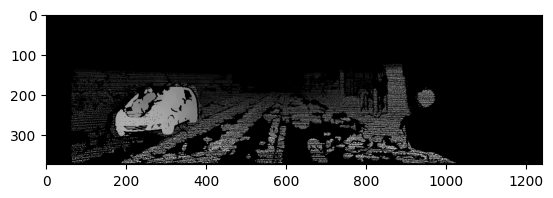

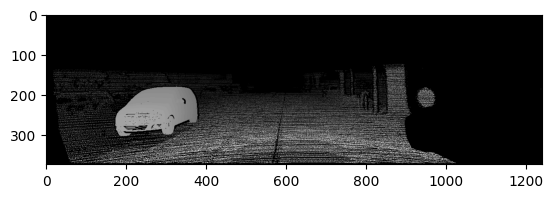

In [91]:
stereo = cv2.StereoSGBM_create(
    numDisparities = 64,
    blockSize = 21,
    P1 = 8, # Common settings
    P2 = 32,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32,
)

disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0
disparity = cv2.normalize(disparity, None, alpha=0, beta=64, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
mask = np.logical_or(disparity == 0, disparity_gn == 0)
masked_RMSE = np.ma.array(np.square(disparity - disparity_gn), mask=mask)
masked_disp = disparity.copy()
masked_disp[mask] = 0
rmse = (np.mean(masked_RMSE))**(0.5)
print(f'Masked RMSE for Stereo SGBM: {rmse} with density: {1 - np.mean(mask)}')
plt.imshow(masked_disp,'gray')
plt.show()
plt.imshow(disparity_gn,'gray')
plt.show()

- Even though the RMSE of SGBM is higher than that of regular BM, if we account for the pixel density, the SGBM is better since the total Error is lower.

## Final Test

In [108]:
left_files = sorted(glob('./stage2_data/stage2_stereo/left_imgs/*'))
right_files = sorted(glob('./stage2_data/stage2_stereo/right_imgs/*'))
dp_files = sorted(glob('./stage2_data/stage2_stereo/disparities/*'))

Best Parameters: max_disparities: 64, block_size: 21
Image 0 masked RMSE : 3.5107998450157507 with density: 0.130825550187869


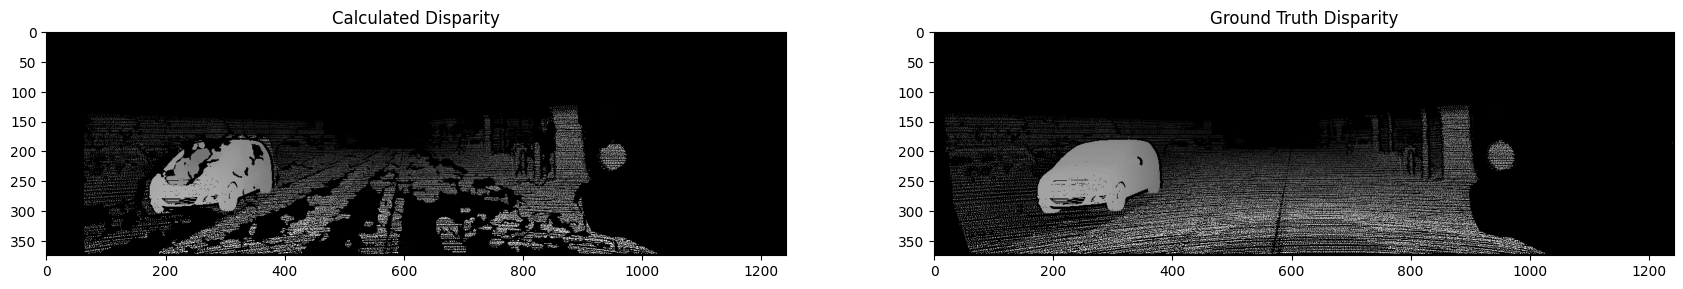

Best Parameters: max_disparities: 112, block_size: 15
Image 1 masked RMSE : 3.4934411220922486 with density: 0.16596027911969946


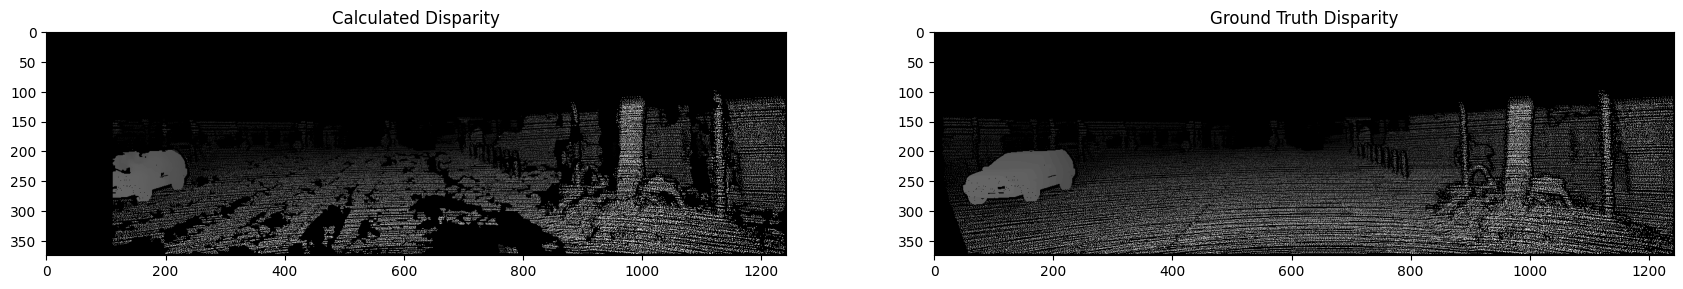

Best Parameters: max_disparities: 80, block_size: 23
Image 2 masked RMSE : 4.125037832288926 with density: 0.11586902844873859


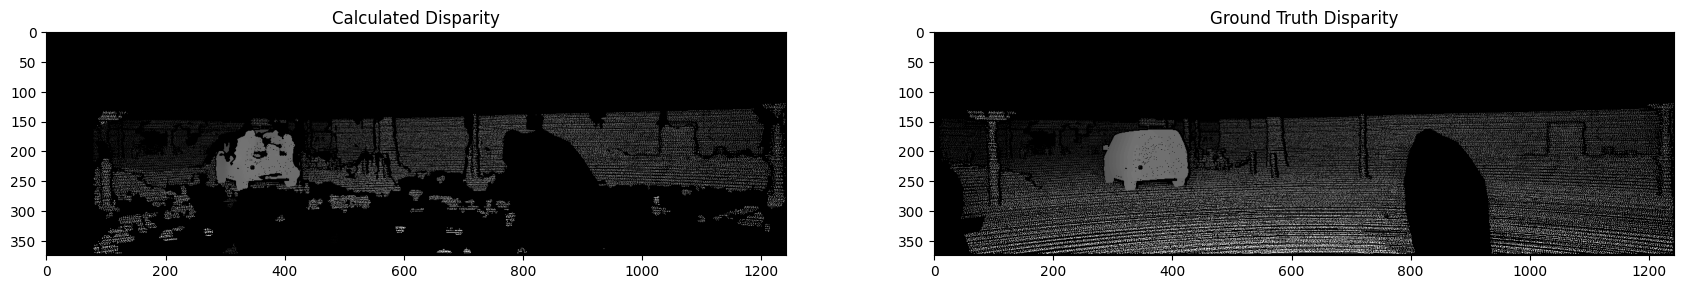

Best Parameters: max_disparities: 80, block_size: 23
Image 3 masked RMSE : 6.327828248299795 with density: 0.10540203972088025


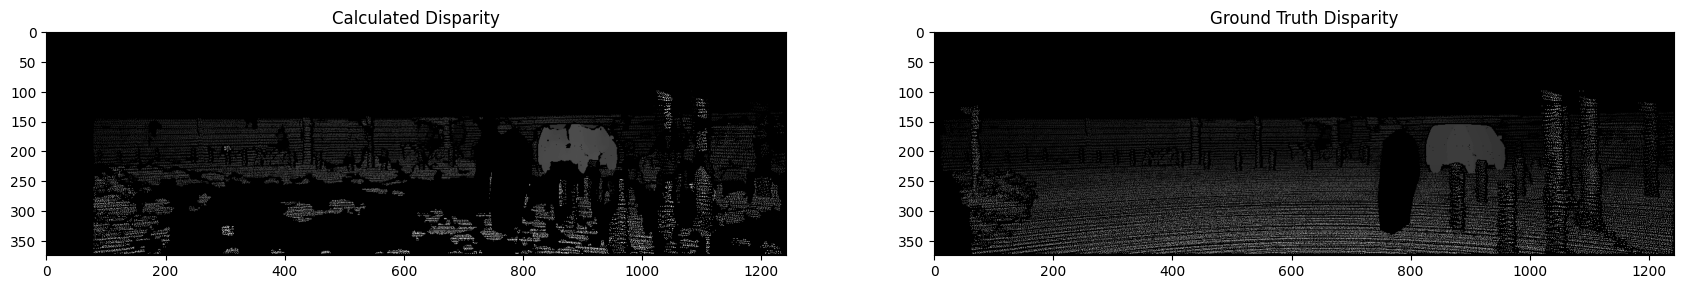

Best Parameters: max_disparities: 112, block_size: 17
Image 4 masked RMSE : 6.426347217475473 with density: 0.11727750939345138


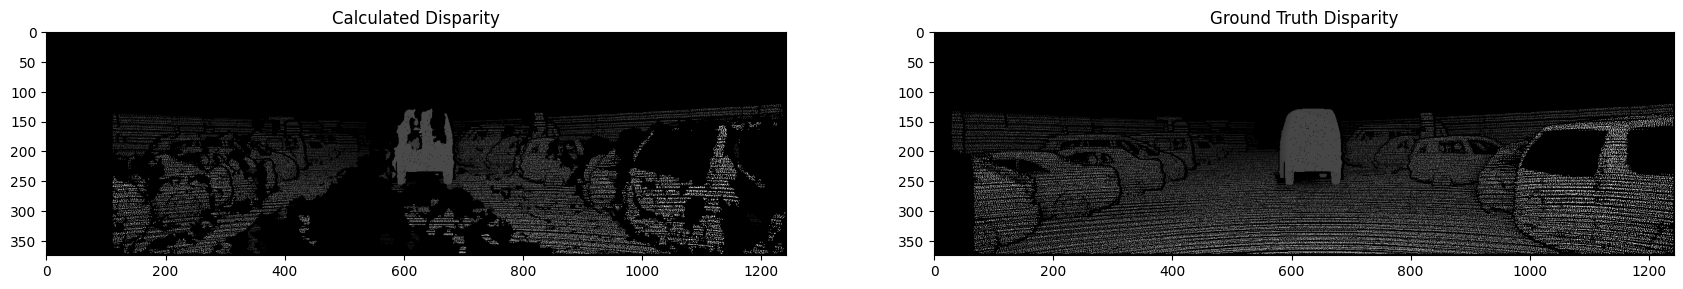

In [111]:
for idx, (L, R, GT) in enumerate(zip(left_files,right_files,dp_files)):
        # Load the left and right images in grayscale
    img_left = cv2.imread(L, 0)
    img_right = cv2.imread(R, 0)
    disparity_gn = cv2.imread(GT, 0)

    max_disparity_list = [i*16 for i in range(1,11)]
    block_size_list = [i for i in range(5,64,2)]
    rmse_list = list()
    min_rmse = 999
    min_parm = tuple

    for max_disparity in max_disparity_list:
        for block_size in block_size_list:
            stereo = cv2.StereoSGBM_create(
                numDisparities = max_disparity,
                blockSize = block_size,
                P1 = 8, # Common settings
                P2 = 32,
                disp12MaxDiff = 1,
                uniquenessRatio = 10,
                speckleWindowSize = 100,
                speckleRange = 32,
            )

            disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0
            disparity = cv2.normalize(disparity, None, alpha=0, beta=max_disparity, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            mask = np.logical_or(disparity == 0, disparity_gn == 0)
            masked_RMSE = np.ma.array(np.square(disparity - disparity_gn), mask=mask)
            rmse = (np.mean(masked_RMSE))**(0.5)
            rmse_list.append(rmse)
            if rmse < min_rmse:
                min_rmse = rmse
                min_parm = (max_disparity, block_size)
                
    stereo = cv2.StereoSGBM_create(
    numDisparities = min_parm[0],
    blockSize = min_parm[1],
    P1 = 8, # Common settings
    P2 = 32,
    disp12MaxDiff = 1,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32,
    )

    disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0
    disparity = cv2.normalize(disparity, None, alpha=0, beta=min_parm[0], norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    mask = np.logical_or(disparity == 0, disparity_gn == 0)
    masked_RMSE = np.ma.array(np.square(disparity - disparity_gn), mask=mask)
    masked_disp = disparity.copy()
    masked_disp[mask] = 0
    rmse = (np.mean(masked_RMSE))**(0.5)
    print(f'Best Parameters: max_disparities: {min_parm[0]}, block_size: {min_parm[1]}')
    print(f'Image {idx} masked RMSE : {rmse} with density: {1 - np.mean(mask)}')
    plt.figure(figsize=(21, 10)) # adjust the size as per your need
    plt.subplot(1, 2, 1) # the figure has 1 row, 2 columns, and this plot is the first plot.
    plt.imshow(masked_disp,'gray')
    plt.title('Calculated Disparity')

    plt.subplot(1, 2, 2) # the figure has 1 row, 2 columns, and this plot is the second plot.
    plt.imshow(disparity_gn, 'gray')
    plt.title('Ground Truth Disparity')

    plt.show()